In [4]:
from importlib import reload
import EEG_with_functions as f
reload(f)

import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import json

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import warnings

In [2]:
folder_path = "Sensor_data_compleet"
list_files = []
for filename in os.listdir(folder_path):
    if os.path.isfile(os.path.join(folder_path, filename)):
        list_files.append(filename)


In [3]:
participant_number = {}
number = 0
for respondent in list_files:
    number += 1
    participant_number[respondent] = number


In [4]:
# Not using this anymore because im now filtering out the stimuli with missing data instead

# with open('part_perc.json', 'r') as json_file:
#     part_perc = json.load(json_file)



In [5]:
list_files[29]

'030_1000573.csv'

23 participanten hebben foute data (dus 40 hebben goede data), waarvan 10 meer dan 1% (dus 13 onder 1%)

  0%|          | 0/1 [00:00<?, ?it/s]

Creating RawArray with float64 data, n_channels=21, n_times=223028
    Range : 0 ... 223027 =      0.000 ...   871.199 secs
Ready.
196 events found on stim channel cue
Event IDs: [10001 10003 10005 10006 10008 10010 10011 10067 10068 10070 10072 10073
 10129 10130 10132 10134 10135 10191 10192 10194 10196 21002 21007 21069
 21131 21193 22004 22009 22071 22133 22195 30001 30002 30003 30004 30005
 30006 30007 30008 30009 30010 30011 30012 30013 30014 30015 30016 30017
 30018 30019 30020 30021 30022 30023 30024 30025 30026 30027 30028 30029
 30030 30031 30032 30033 30034 30035 30036 30037 30038 30039 30040 30041
 30042 30043 30044 30045 30046 30047 30048 30049 30050 30051 30052 30053
 30054 30055 30056 30057 40001 40002 40003 40004 40005 40006 40007 40008
 40009 40010 40011 40012 40013 40014 40015 40016 40017 40018 40020 40021
 40022 40023 40024 40025 40026 40027 40028 40029 40030 40031 40032 40033
 40034 40035 40036 40037 40039 40040 40041 40042 40043 40044 40045 40046
 40047 40048 40049

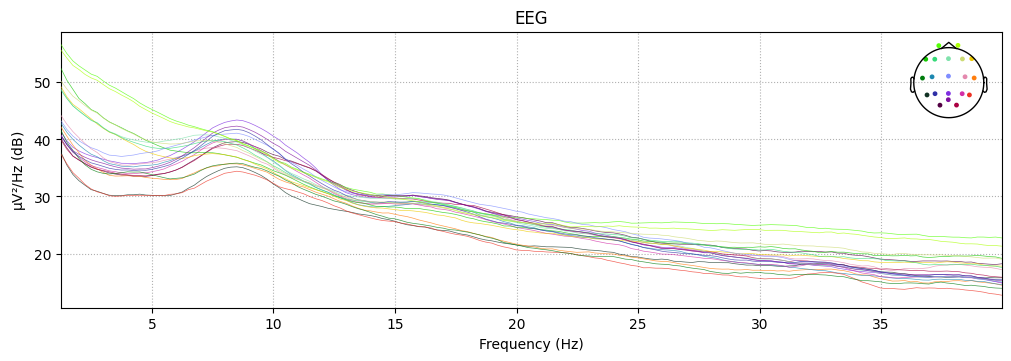

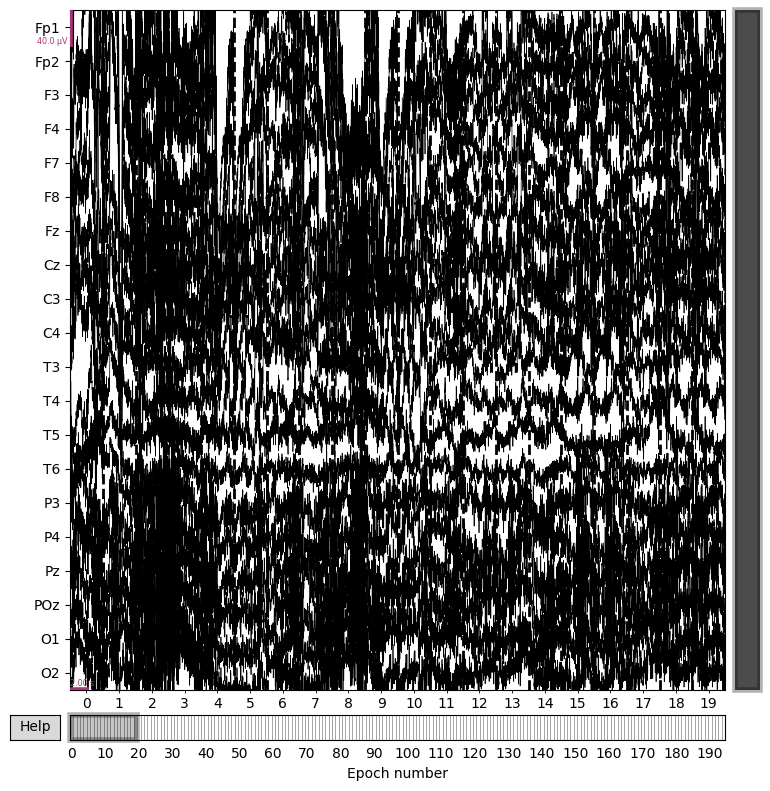

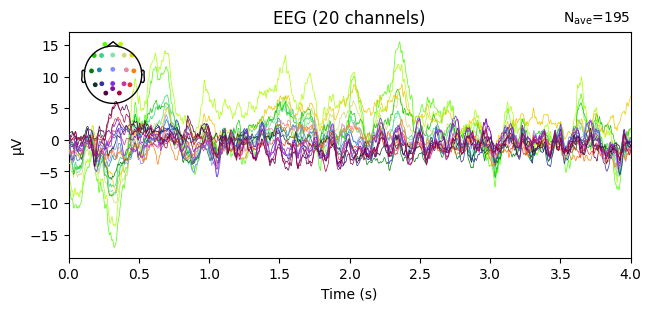

Not setting metadata
54 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 54 events and 129 original time points ...
0 bad epochs dropped
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective window size : 0.504 (s)
Effective wind

100%|██████████| 1/1 [01:46<00:00, 106.89s/it]

Error occurred for participant 1: NameError at line 40


In [7]:
# %%capture
warnings.filterwarnings("ignore")
reload(f)
dfs = []
error_list = {}
for par in tqdm(list_files[:1]):
    # if part_perc[par] == 0.0: #participants without faulty rows in their file don't occur the first problem
    try: 
        participant = participant_number[par]
        res = f.import_data(par, "Sensor_data_compleet", "./")
        info, sampling_freq, n_channels, ch_names, ch_types = f.metadata()
        only_electrodes = ch_names
        res = f.stim_channels(res)

        stimuli_dict, res = f.change_stimuli_names(res)
        res, media, stimuli_dict, missing_dict = f.flag_missing_events(res, only_electrodes, stimuli_dict) #nog een fout door deze functie

        info, channel_names = f.make_mne_object(info, sampling_freq, n_channels, only_electrodes, ch_types)
        res = f.remove_nas(res, only_electrodes)
        raw = f.convertto_raw(res, channel_names, info)
        raw_filter = f.filter_raw(raw)
        events, baseline_list, fixcross_list, stimuli_list = f.extract_events(raw_filter)
        epochs = f.create_epochs(raw_filter, events, "yes")
        low_cutoff, high_cutoff, notch_freq, artifact_threshold, n_fft, n_overlap = f.parameters(1.0, 0.1)
        # FAA3dim_all_images, spectrum = f.calculate_faa_3dim(epochs, n_overlap, n_fft, 256)
        # FAA2dim = f.calculate_faa_2dim(spectrum)

        baseline_features_FAA, baseline_epochs = f.baseline_features_FAA(raw_filter, events, fixcross_list, sampling_freq, participant) #LET OP BASELINE LIST OF FIXCROSS LIST
        stimuli_features_FAA, stimuli_epochs = f.stimuli_features_FAA(raw_filter, events, stimuli_list, sampling_freq, participant)
        baseline_features_psd = f.create_baseline_features_df(events, baseline_epochs, only_electrodes, participant, res, missing_dict)
        stimuli_features_psd = f.create_stimuli_features_df(events, stimuli_epochs, only_electrodes, participant, res, missing_dict)
        baseline_features = pd.merge(baseline_features_psd, baseline_features_FAA[["ID", "FAA"]], on = "ID", how = "left")
        stimuli_features = pd.merge(stimuli_features_psd, stimuli_features_FAA[["ID", "FAA"]], on = "ID", how = "left")
        base_to_stimulus = f.match_bl_to_stimuli(stimuli_dict)
        features_individual = f.baseline_correction(baseline_features, stimuli_features)
        dfs.append(features_individual)

        features_individual["Participant_ID"] = par

        
    except Exception as e:
        error_type = type(e).__name__
        line_number = e.__traceback__.tb_lineno
        print(f"Error occurred for participant {participant}: {error_type} at line {line_number}")  
        error_list[par] = {
            'error_type': error_type,
            'line_number': line_number,
            'exception': e}



Using data from preloaded Raw for 195 events and 1025 original time points ...


Effective window size : 1.000 (s)


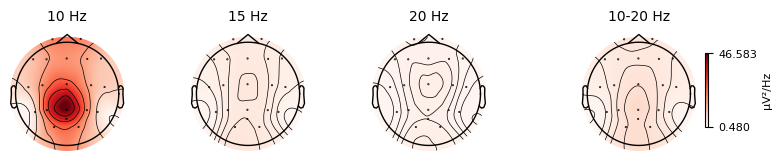

Using data from preloaded Raw for 20 events and 1025 original time points ...


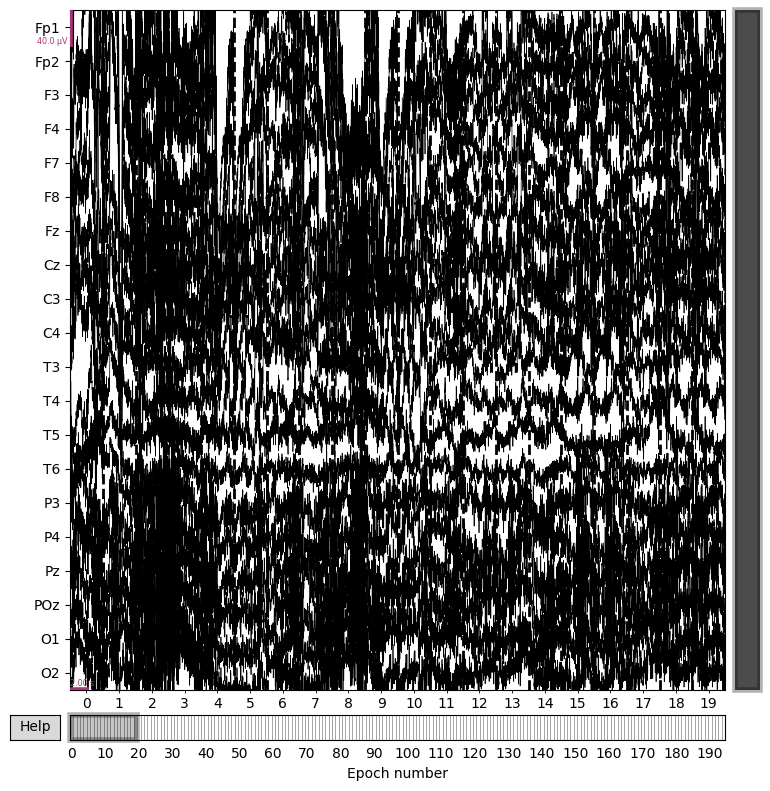

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Using data from preloaded Raw for 195 events and 1025 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


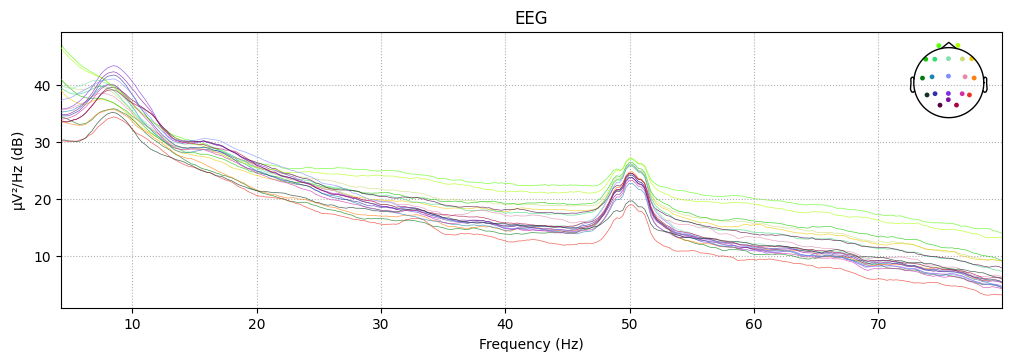

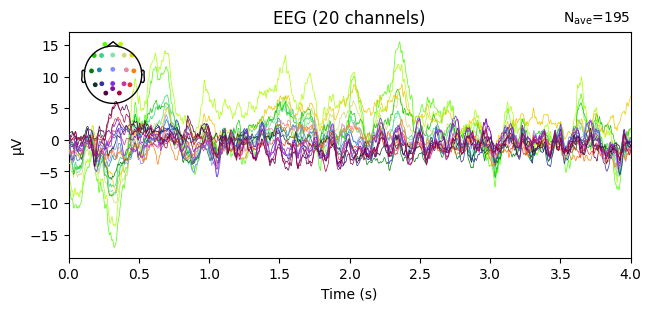

In [12]:
reload(f)
f.visualization(epochs,"yes")

In [8]:
error_list

{'001_1000734.csv': {'error_type': 'NameError',
  'line_number': 40,
  'exception': NameError("name 'visualization' is not defined")}}

In [15]:
def assign_class(number):
    if number in [1, 2]: #negative
        return 0
    elif number in [3, 4, 5]: #neutral
        return 1
    elif number in [6, 7]: #positive
        return 2
    else:
        return None 

In [16]:
features = pd.concat(dfs, ignore_index=True)  
survey = f.import_survey_df()
ratings_dict = f.get_ratings(stimuli_list, survey)
features["mean_rating"] = features["ID"].map(ratings_dict)
features = f.get_individual_ratings(features, survey)
features["class"] = features["individual_ratings"].apply(assign_class)
features = features[features["Missing"] != "yes"]
features.to_csv('features2.csv', index=False)

In [17]:
features

,Respondent,Participant_ID,mean_rating,Participant_ID_short,image_number,individual_ratings,Missing,ID,Type,Fp1_4hz,...,O2_73hz,O2_74hz,O2_75hz,O2_76hz,O2_77hz,O2_78hz,O2_79hz,O2_80hz,FAA,class
0,1,001_1000734.csv,3.846154,1000734,6,5.0,no,60006,neu,4.258225e-12,...,1.532729e-14,8.159648e-15,-6.107845e-15,-1.585692e-14,-3.056100e-15,-7.035361e-16,3.201438e-14,2.750970e-14,-1.946338,1
1,1,001_1000734.csv,6.307692,1000734,3,6.0,no,50003,pos,9.472812e-13,...,5.643239e-15,3.568787e-15,6.979046e-15,2.131366e-14,1.990946e-14,2.531661e-14,3.442426e-14,5.278059e-15,-0.804592,2
2,1,001_1000734.csv,5.492308,1000734,4,4.0,no,50004,pos,1.431861e-09,...,3.650822e-15,-1.281375e-14,4.474159e-15,1.659858e-14,4.330363e-14,3.274820e-14,1.146045e-14,1.967159e-14,-0.899335,1
3,1,001_1000734.csv,1.738462,1000734,6,3.0,no,70006,neg,3.444840e-12,...,-7.083389e-15,4.273116e-14,2.304741e-14,-1.124750e-14,-9.658057e-15,3.836625e-15,3.797278e-15,-1.413163e-14,0.701186,1
4,1,001_1000734.csv,5.953846,1000734,2,6.0,no,50002,pos,-1.738827e-12,...,2.643302e-14,1.404321e-14,8.908602e-15,7.800026e-15,3.591903e-15,6.970471e-16,-1.145148e-14,-8.128278e-15,-0.149031,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3119,63,065_1000675.csv,5.953846,1000675,2,6.0,no,50202,pos,2.734432e-12,...,1.971934e-14,-2.447027e-14,-4.825855e-14,2.372797e-14,3.241210e-14,1.021307e-15,-3.010152e-15,-2.960910e-15,1.596881,2
3120,63,065_1000675.csv,6.138462,1000675,1,7.0,no,50201,pos,-1.237949e-12,...,1.604572e-14,5.535198e-14,2.079934e-14,-1.124288e-14,9.519784e-15,3.107645e-14,1.601948e-14,1.420144e-14,1.180062,2
3121,63,065_1000675.csv,4.923077,1000675,6,6.0,no,50206,pos,2.474029e-10,...,2.406219e-14,1.083029e-14,1.892534e-14,1.651640e-14,3.912297e-15,-3.700446e-15,5.005764e-15,9.256910e-15,-1.103716,2
3122,63,065_1000675.csv,4.569231,1000675,1,4.0,no,60201,neu,5.395750e-12,...,1.610586e-14,1.772994e-14,1.057404e-14,-2.168393e-15,-1.134448e-14,-1.211917e-14,-4.127085e-15,1.813581e-15,1.673359,1


In [11]:
int(features.columns[20][-4:-2]) in range(10,15)

False

Tekort aan baselines gaat fout na change_stimuli_names

IPV interpoleren/rows skippen de epochs maken op basis van time stamp en niet op rows als je rows weg wilt halen, dan klopt 300 - 700 ms namelijk niet meer. Kijk nog even goed hoe het eruit ziet en stuur naar Nikki.
Drie modellen met elkaar vergelijken is normaal in data science. compute_psd parameters kunnen weg want er is toch geen overlap in 400 ms. Support vector machine/

In [12]:
t = np.array(res["C3"])
len(t[t == 50])/len(t) * 100

0.0

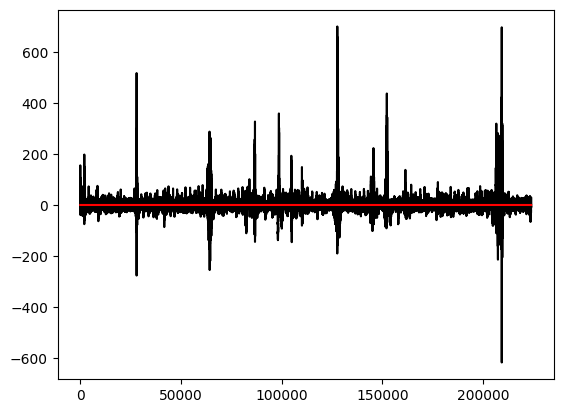

In [13]:
plt.plot(t, color = "black")
plt.plot((t == 50) * 500, color = "red")
plt.show()